# Image generation with Segmind Stable Diffusion 1B (SSD-1B) model and OpenVINO

The [Segmind Stable Diffusion Model (SSD-1B)](https://github.com/segmind/SSD-1B?ref=blog.segmind.com) is a distilled 50% smaller version of the Stable Diffusion XL (SDXL), offering a 60% speedup while maintaining high-quality text-to-image generation capabilities. It has been trained on diverse datasets, including Grit and Midjourney scrape data, to enhance its ability to create a wide range of visual content based on textual prompts.
This model employs a knowledge distillation strategy, where it leverages the teachings of several expert models in succession, including SDXL, ZavyChromaXL, and JuggernautXL, to combine their strengths and produce impressive visual outputs.

![image](https://user-images.githubusercontent.com/82945616/277419571-a5583e8a-6a05-4680-a540-f80502feed0b.png)


In this tutorial, we consider how to run the SSD-1B model using OpenVINO.

We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format.

#### Table of contents:
- [Install Prerequisites](#Install-prerequisites-Uparrow)
- [SSD-1B Base model](#SSD-1B-Base-model-Uparrow)
- [Select inference device SSD-1B Base model](#Select-inference-device-SSD-1B-Base-model-Uparrow)
- [Text2image Generation Interactive Demo](#Text2image-Generation-Interactive-Demo-Uparrow)

### Install prerequisites [$\Uparrow$](#Table-of-content:)

In [ ]:
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q "openvino>=2023.1.0"
%pip install -q --upgrade-strategy eager "invisible-watermark>=0.2.0" "transformers>=4.33" "accelerate" "onnx" "onnxruntime" safetensors "diffusers>=0.22.0"
%pip install -q gradio

### SSD-1B Base model [$\Uparrow$](#Table-of-content:)

We will start with the base model part, which is responsible for the generation of images of the desired output size. 
[SSD-1B](https://huggingface.co/segmind/SSD-1B) is available for downloading via the [HuggingFace hub](https://huggingface.co/models). It already provides a ready-to-use model in OpenVINO format compatible with [Optimum Intel](https://huggingface.co/docs/optimum/intel/index).

To load an OpenVINO model and run an inference with OpenVINO Runtime, you need to replace diffusers `StableDiffusionXLPipeline` with Optimum `OVStableDiffusionXLPipeline`. In case you want to load a PyTorch model and convert it to the OpenVINO format on the fly, you can set `export=True`.  

You can save the model on disk using the `save_pretrained` method.

In [1]:
from pathlib import Path
from optimum.intel.openvino import OVStableDiffusionXLPipeline


model_id = "segmind/SSD-1B"
model_dir = Path("openvino-ssd-1b")

/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


### Select inference device SSD-1B Base model [$\Uparrow$](#Table-of-content:)

select device from dropdown list for running inference using OpenVINO

In [2]:
import ipywidgets as widgets
import openvino as ov


core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [3]:
import gc


if not model_dir.exists():
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_id, compile=False, device=device.value, export=True)
    text2image_pipe.half()
    text2image_pipe.save_pretrained(model_dir)
    text2image_pipe.compile()
    gc.collect()
else:
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...
Compiling the text_encoder to AUTO ...


### Run Text2Image generation pipeline [$\Uparrow$](#Table-of-content:)

Now, we can run the model for the generation of images using text prompts. To speed up evaluation and reduce the required memory we decrease `num_inference_steps` and image size (using `height` and `width`).  You can modify them to suit your needs and depend on the target hardware. We also specified a `generator` parameter based on a numpy random state with a specific seed for results reproducibility.
>**Note**: Generating a default size 1024x1024 image requires about 53GB for the SSD-1B model in case if the converted model is loaded from disk and up to 64GB RAM for the SDXL model after exporting.

/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/optimum/intel/openvino/modeling_diffusion.py:565: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/optimum/intel/openvino/modeling_diffusion.py:599: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)
/home/maleksandr/test_notebooks/ssd-1b-pr/openvino_notebooks/notebooks/248-stable-diffusion-xl/venv/lib/python3.10/site-packages/optimum/intel/openvino/modeling_diffusion.py:615: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


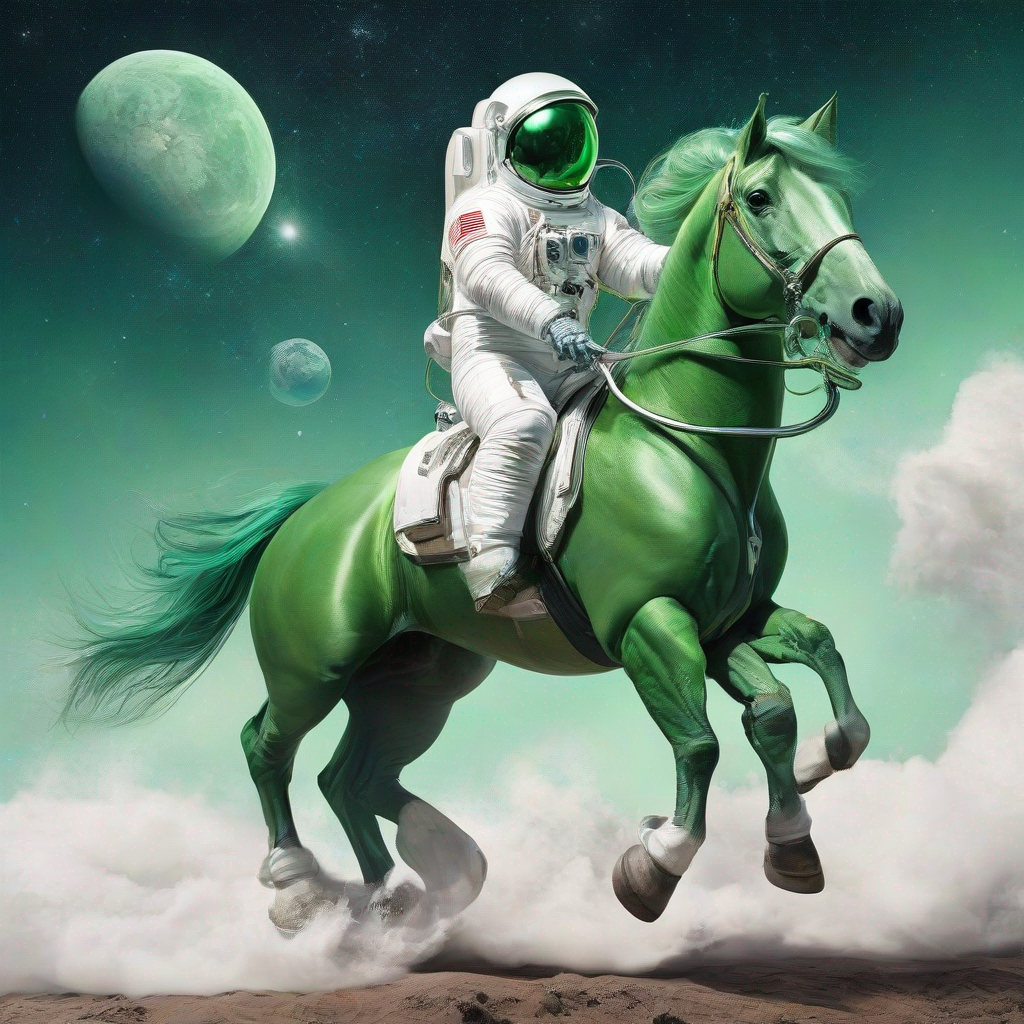

In [4]:
prompt = "An astronaut riding a green horse"  # Your prompt here
neg_prompt = "ugly, blurry, poor quality"  # Negative prompt here
image = text2image_pipe(prompt=prompt, num_inference_steps=15, negative_prompt=neg_prompt).images[0]
image

Generating a 512x512 image requires about 27GB for the SSD-1B model and about 42GB RAM for the SDXL model in case if the converted model is loaded from disk.

  0%|          | 0/15 [00:00<?, ?it/s]

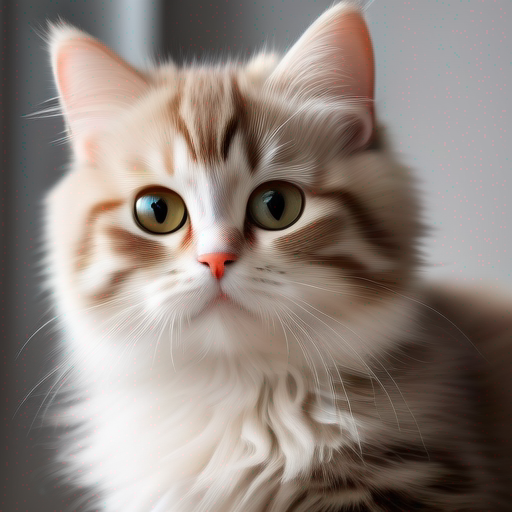

In [5]:
import numpy as np


prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
image = text2image_pipe(prompt, num_inference_steps=15, height=512, width=512, generator=np.random.RandomState(314)).images[0]
image

### Image2Image Generation Interactive Demo [$\Uparrow$](#Table-of-content:)

In [ ]:
import gradio as gr
import numpy as np


prompt = "An astronaut riding a green horse"
neg_prompt = "ugly, blurry, poor quality"

def generate_from_text(text_promt, neg_prompt, seed, num_steps):
    result = text2image_pipe(text_promt, negative_prompt=neg_prompt, num_inference_steps=num_steps, generator=np.random.RandomState(seed), height=512, width=512).images[0]
    return result


with gr.Blocks() as demo:
    with gr.Column():
        positive_input = gr.Textbox(label="Text prompt")
        neg_input = gr.Textbox(label="Negative prompt")
        with gr.Row():
            seed_input = gr.Slider(0, 10_000_000, value=42, label="Seed")
            steps_input = gr.Slider(label="Steps", value=10)
            btn = gr.Button()
        out = gr.Image(label="Result", type="pil", width=512)
        btn.click(generate_from_text, [positive_input, neg_input, seed_input, steps_input], out)
        gr.Examples([
            [prompt, neg_prompt, 999, 20], 
            ["underwater world coral reef, colorful jellyfish, 35mm, cinematic lighting, shallow depth of field,  ultra quality, masterpiece, realistic", neg_prompt, 89, 20],
            ["a photo realistic happy white poodle dog ​​playing in the grass, extremely detailed, high res, 8k, masterpiece, dynamic angle", neg_prompt, 1569, 15],
            ["Astronaut on Mars watching sunset, best quality, cinematic effects,", neg_prompt, 65245, 12],
            ["Black and white street photography of a rainy night in New York, reflections on wet pavement", neg_prompt, 48199, 10]
        ], [positive_input, neg_input, seed_input, steps_input])

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/